In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import glob
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Input,Activation, Dense, Flatten ,MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model,save_model
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

In [3]:
path  = "/kaggle/input/fer2013/"

In [4]:
image_list = os.listdir(path)
image_list

['test', 'train']

In [5]:
image_filenames = glob.glob(os.path.join(path,'**/*.jpg'), recursive=True)

# create an info dataframe
df = pd.DataFrame({'filename': image_filenames})
df['partition'] = df['filename'].apply(lambda x: x.split(os.sep)[-3])
df['label'] = df['filename'].apply(lambda x: x.split(os.sep)[-2])

df

,filename,partition,label
0,/kaggle/input/fer2013/test/surprise/PublicTest...,test,surprise
1,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
2,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
3,/kaggle/input/fer2013/test/surprise/PublicTest...,test,surprise
4,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
...,...,...,...
35882,/kaggle/input/fer2013/train/happy/Training_188...,train,happy
35883,/kaggle/input/fer2013/train/happy/Training_165...,train,happy
35884,/kaggle/input/fer2013/train/happy/Training_108...,train,happy
35885,/kaggle/input/fer2013/train/happy/Training_304...,train,happy


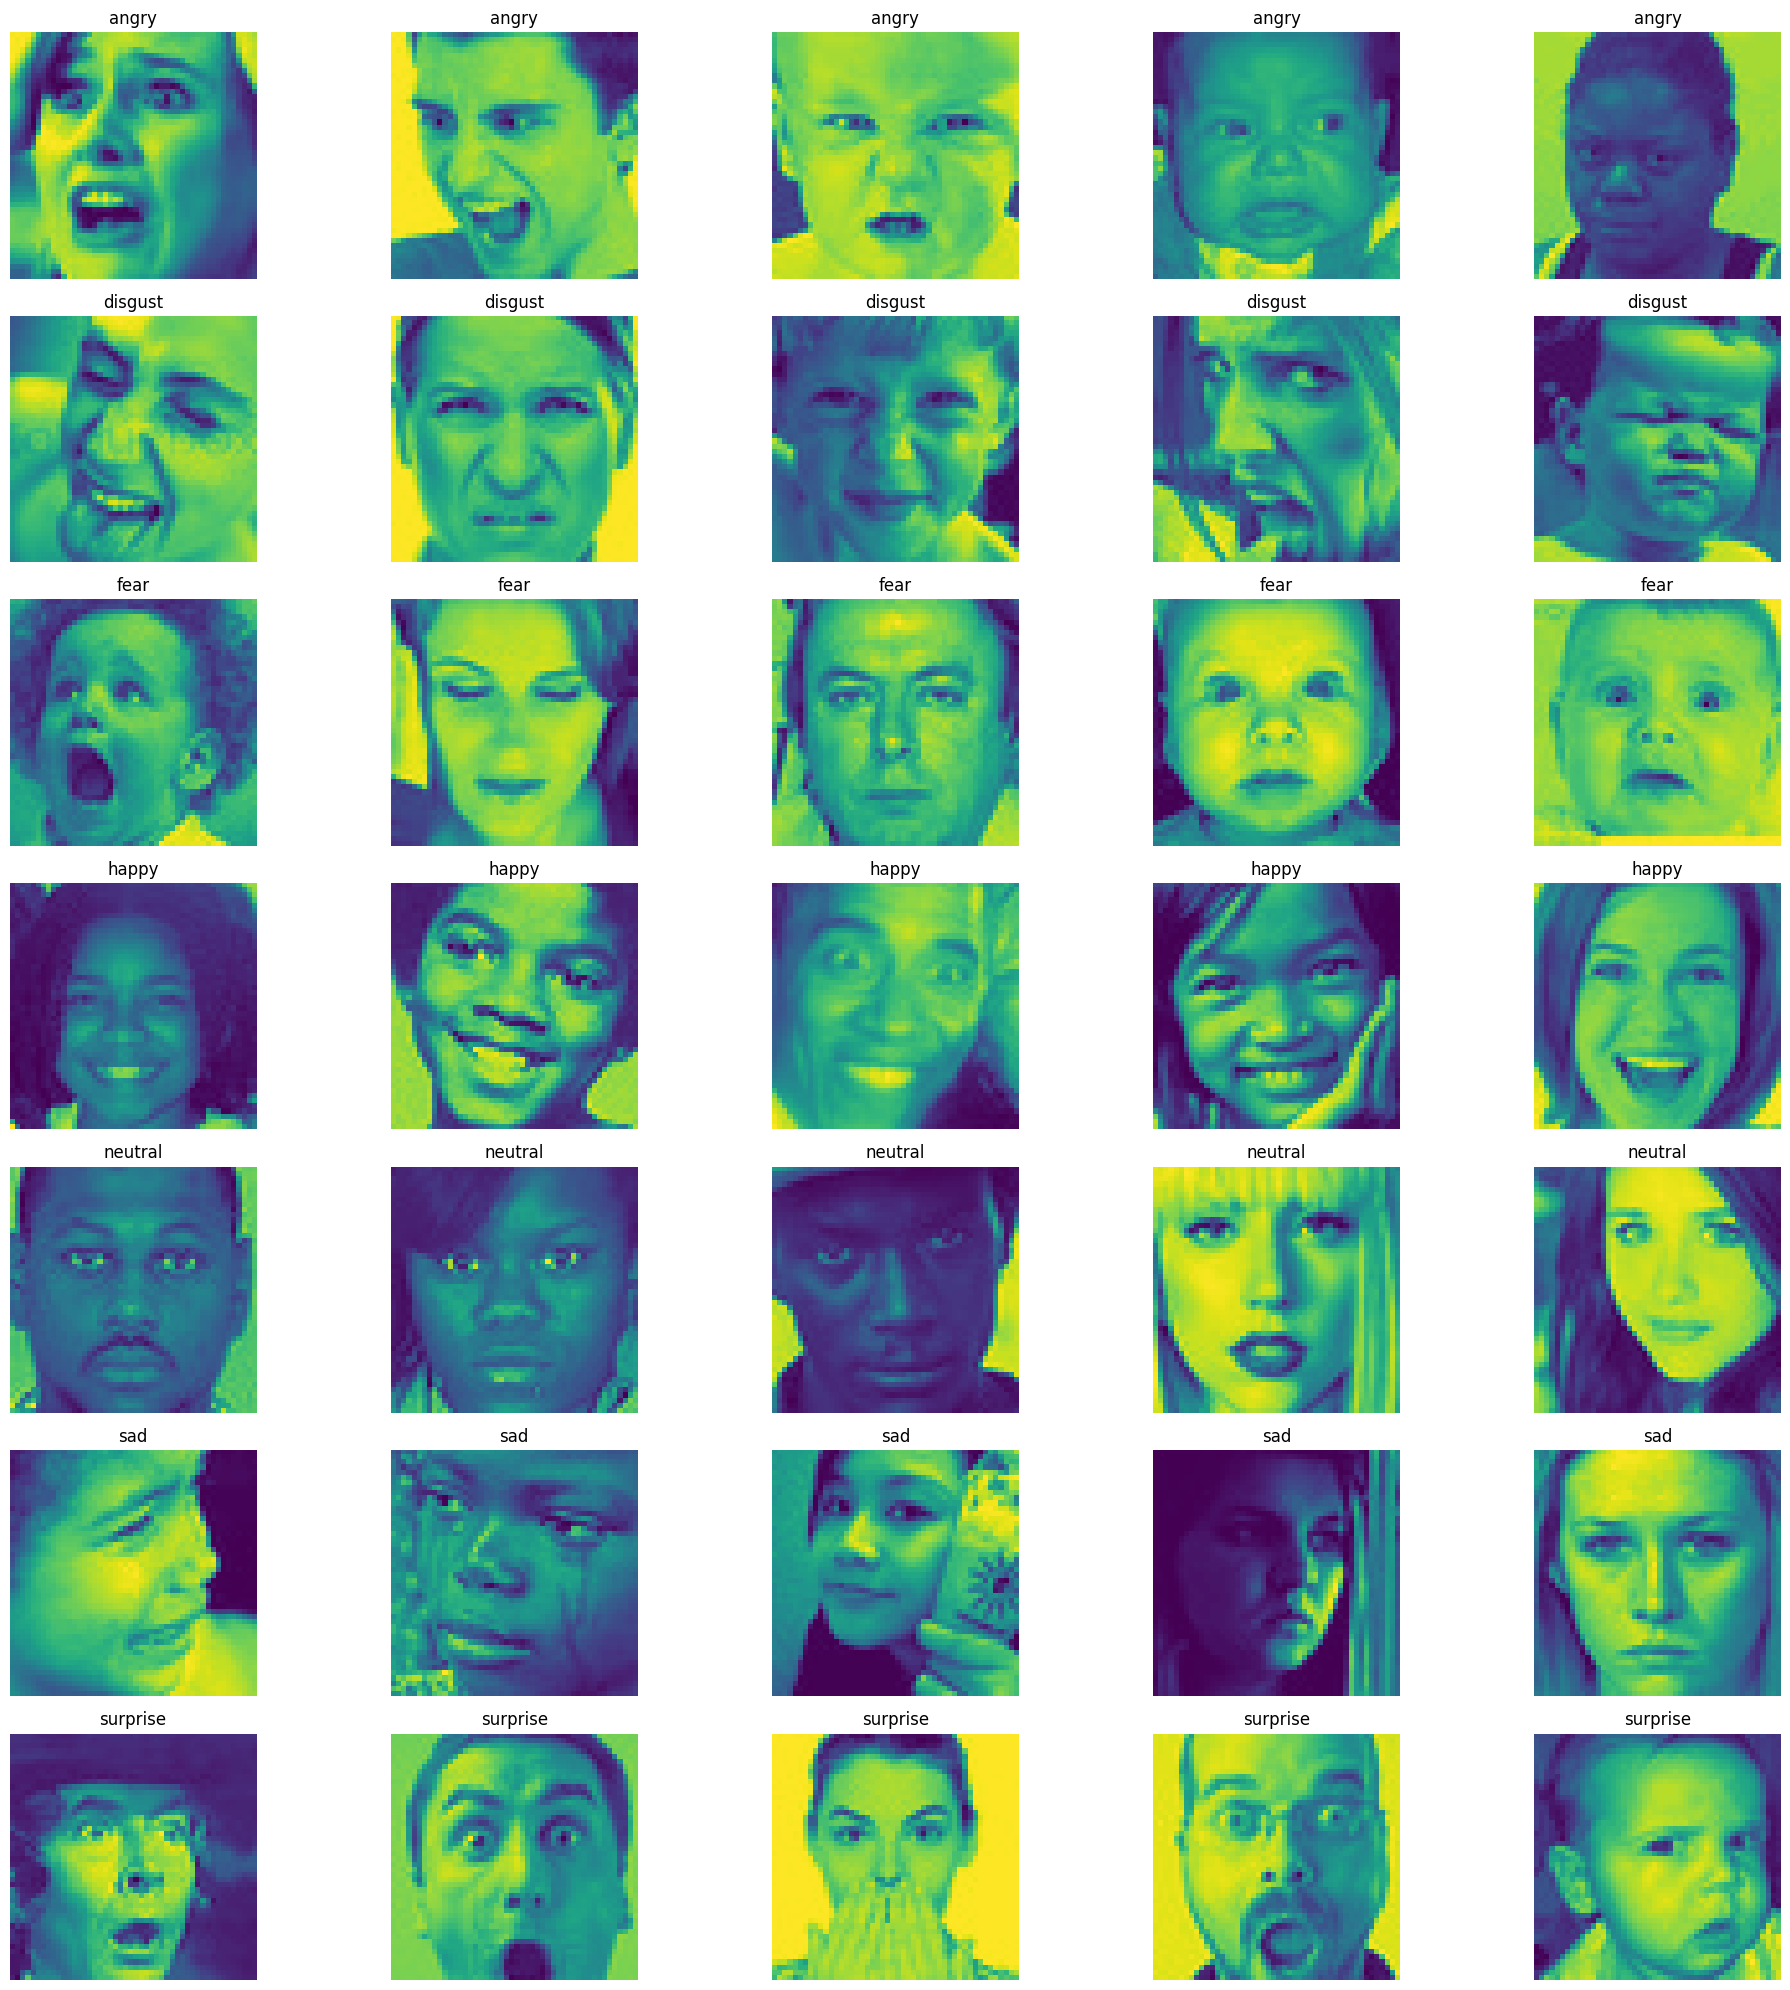

In [6]:
fig, axs = plt.subplots(7, 5, figsize=(20,20))
for i in range(5):
    axs.flat[i].imshow(plt.imread( df.query('label == "angry"')['filename'].iloc[i]))
    axs.flat[i].set_title(str("angry"))
    axs.flat[i].axis('off')
    
for i in range(5):
    axs.flat[i+5].imshow(plt.imread( df.query('label == "disgust"')['filename'].iloc[i]))
    axs.flat[i+5].set_title(str("disgust"))
    axs.flat[i+5].axis('off')

for i in range(5):
    axs.flat[i+10].imshow(plt.imread( df.query('label == "fear"')['filename'].iloc[i]))
    axs.flat[i+10].set_title(str("fear"))
    axs.flat[i+10].axis('off')

for i in range(5):
    axs.flat[i+15].imshow(plt.imread( df.query('label == "happy"')['filename'].iloc[i]))
    axs.flat[i+15].set_title(str("happy"))
    axs.flat[i+15].axis('off')
    
for i in range(5):
    axs.flat[i+20].imshow(plt.imread( df.query('label == "neutral"')['filename'].iloc[i]))
    axs.flat[i+20].set_title(str("neutral"))
    axs.flat[i+20].axis('off')
    
for i in range(5):
    axs.flat[i+25].imshow(plt.imread( df.query('label == "sad"')['filename'].iloc[i]))
    axs.flat[i+25].set_title(str("sad"))
    axs.flat[i+25].axis('off')
    
for i in range(5):
    axs.flat[i+30].imshow(plt.imread( df.query('label == "surprise"')['filename'].iloc[i]))
    axs.flat[i+30].set_title(str("surprise"))
    axs.flat[i+30].axis('off')
    
plt.tight_layout()
plt.show()


In [7]:
image_generator=ImageDataGenerator(rescale=1/255)


Training = image_generator.flow_from_directory('/kaggle/input/fer2013/train',target_size=(48,48),
                                            batch_size=64,class_mode='categorical',shuffle=True)


Test = image_generator.flow_from_directory('/kaggle/input/fer2013/test' ,target_size=(48,48),
                                            batch_size=64,class_mode='categorical',shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
df['label'].value_counts(ascending=True)

label
disgust      547
surprise    4002
angry       4953
fear        5121
sad         6077
neutral     6198
happy       8989
Name: count, dtype: int64

In [9]:
print(Training.class_indices)
print(Test.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [10]:
classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

#2nd CNN layer
model.add(Conv2D(128,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.3))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.3))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(classes, activation='softmax'))



opt = Adam(lr = 0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       7

In [11]:
train_step=Training.n//Training.batch_size
test_step=Test.n//Test.batch_size


num_epochs = 20

#checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience= 4,
                          verbose=1,
                          restore_best_weights=True
                          )

model_checkpoint = ModelCheckpoint('best_model_1.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")

callbacks_list = [early_stopping,reduce_learningrate,model_checkpoint]

history = model.fit_generator(Training,
                                      steps_per_epoch=train_step,
                                      epochs=num_epochs, 
                                      validation_data=Test,
                                      validation_steps=test_step,
                                      callbacks=callbacks_list) 

/tmp/ipykernel_34/3087810174.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(Training,


Epoch 1/20


2024-02-16 13:38:53.003877: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708090736.722436     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 [==============================] - ETA: 0s - loss: 1.8144 - accuracy: 0.3043
Epoch 1: val_accuracy improved from -inf to 0.35045, saving model to best_model_1.h5
448/448 [==============================] - 188s 401ms/step - loss: 1.8144 - accuracy: 0.3043 - val_loss: 1.7494 - val_accuracy: 0.3504 - lr: 0.0010
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - ETA: 0s - loss: 1.4445 - accuracy: 0.4464
Epoch 2: val_accuracy improved from 0.35045 to 0.47084, saving model to best_model_1.h5
448/448 [==============================] - 39s 88ms/step - loss: 1.4445 - accuracy: 0.4464 - val_loss: 1.3874 - val_accuracy: 0.4708 - lr: 0.0010
Epoch 3/20
448/448 [==============================] - ETA: 0s - loss: 1.2989 - accuracy: 0.5015
Epoch 3: val_accuracy improved from 0.47084 to 0.52567, saving model to best_model_1.h5
448/448 [==============================] - 36s 81ms/step - loss: 1.2989 - accuracy: 0.5015 - val_loss: 1.2398 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 4/20
448/448 [==============================] - ETA: 0s - loss: 1.2228 - accuracy: 0.5370
Epoch 4: val_accuracy did not improve from 0.52567
448/448 [==============================] - 39s 87ms/step - loss: 1.2228 - accuracy: 0.5370 - val_loss: 1.4239 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 5/20
448/448 [==============================] - ETA:

In [12]:
score = model.evaluate(Test)
print(score)

113/113 [==============================] - 7s 62ms/step - loss: 0.9990 - accuracy: 0.6460
[0.9989502429962158, 0.6460016965866089]


In [13]:
print(Test.filepaths[1000])
print('--------------------------------------')
print(Test.classes[1000])

/kaggle/input/fer2013/test/disgust/PrivateTest_85928336.jpg
--------------------------------------
1


1/1 [==============================] - 0s 373ms/step


Text(0.5, 1.0, 'happy')

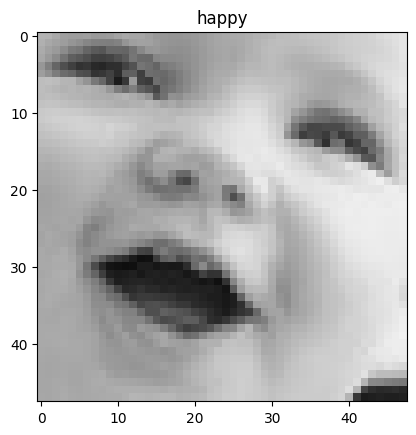

In [14]:
images,labels=Test.next()
pred=np.argmax(model.predict(tf.expand_dims(images[1],axis=0)))

ls = list(Test.class_indices.keys())

plt.imshow(images[1])
plt.title(ls[pred])

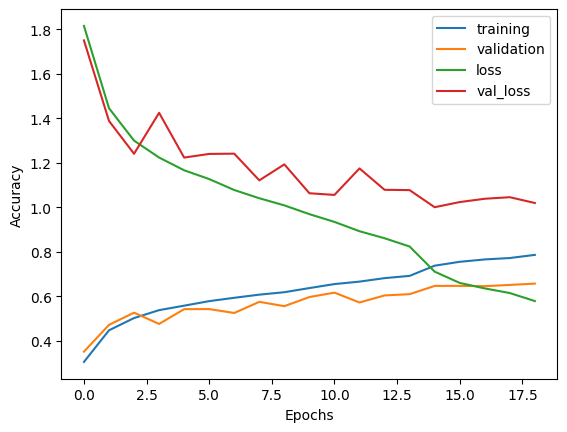

In [15]:
plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='validation')
plt.plot(history.history["loss"],label='loss')
plt.plot(history.history["val_loss"],label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
preds = model.predict(Test)
y_pred = np.argmax(preds , axis = 1 )


In [ ]:
y_pred

/tmp/ipykernel_34/523660850.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(Test)


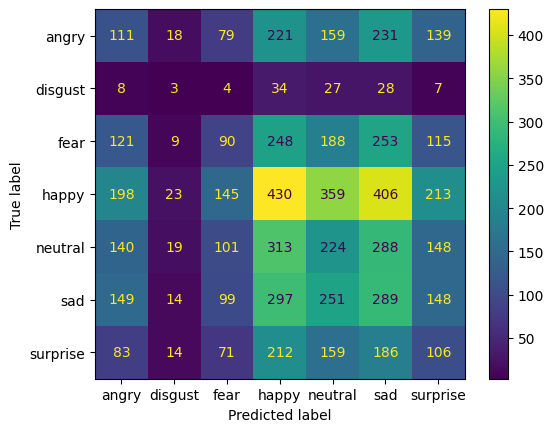

In [16]:
y_pred = model.predict_generator(Test)
y_pred_classes = np.argmax(y_pred, axis = 1)

ConfusionMatrixDisplay(confusion_matrix(Test.classes,y_pred_classes),
                       display_labels=list(Training.class_indices.keys())).plot()

In [44]:
model.save('my_model.h5')

In [46]:
# Loading the best fit model 
from keras.models import load_model
model = load_model("my_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       7